In [1]:

import matplotlib.pyplot as plt
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import numpy as np
import time as tm
import scanpy as sc
import anndata
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from scipy.io import mmread
import torch
from dataset import setup_seed,train_test_valid_loader_setup,get_accuracy #
from model import tre
from train import run_inference_for_epoch,get_evaluate_loss,lossplot
torch.set_default_tensor_type(torch.FloatTensor)
import pyro
from pyro.infer import SVI,  JitTraceEnum_ELBO, Trace_ELBO, config_enumerate
from pyro.optim import Adam, ExponentialLR
from sklearn.metrics import accuracy_score, f1_score
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
from model import tre

In [3]:

input_path = "dataa549"
output_path = "outputa549"

In [4]:
torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2080 Ti'

In [5]:
#Set the missing initial value
setup_seed(233)
learning_rate =3e-4#1e-3
decay_rate = 0.97
enum_discrete = "parallel"
beta_1 = 0.99
cuda = True
float64 = False
config_enum = "parallel"
validation_fold = 0.1
batch_size = 30
test_size=0.3
unsuptrain_size=0.3
valid_size=0.1
sup_num, unsup_num = 0, 0

In [6]:
a549_dataset = {
                "gene_names": 'gene_names.txt',
                "gene_expression": 'rna_count.mtx',
                "cell_barcodes": 'cell_barcodes.txt',
                "atac_scores": 'atac_score.mtx',
                "label": 'label_file.csv',
                "mask": 'tf_gene.csv',
                }
datafile=mmread("{}/{}".format(input_path ,a549_dataset ["gene_expression"])).todense()
gene_names=pd.read_csv("{}/{}".format(input_path ,a549_dataset ["gene_names"]), header=None)
barcodes=pd.read_csv("{}/{}".format(input_path ,a549_dataset ["cell_barcodes"]), header=None)
acc_p=mmread("{}/{}".format(input_path ,a549_dataset ["atac_scores"])).todense()
mask=pd.read_csv("{}/{}".format(input_path ,a549_dataset ["mask"]), header=0,index_col=0)
label_file=pd.read_csv("{}/{}".format(input_path ,a549_dataset ["label"]), header=0,index_col=0)


In [7]:
datafile=pd.DataFrame(datafile.T,index=barcodes.values[:,0],columns=gene_names.values[:,0])
#Input data preprocess
tfname=mask
classnum=len(np.unique(label_file))
savebarcode=pd.DataFrame(datafile.index)
barcode=savebarcode.index.tolist()
label_file=label_file.values
datafile=datafile.values
acc_p=acc_p.T
acc_p=acc_p.astype(np.float32)
datafile=datafile.astype(np.float32)
mask=mask.values

In [8]:
#Setup dataloader

data_loaders = {'sup':None, 'unsup':None, 'valid':None ,'test':None}
data_loaders['sup'],data_loaders['valid'],data_loaders['unsup'],data_loaders['test'] = train_test_valid_loader_setup(datafile,label_file,acc_p,barcode,classnum,cuda,float64,batch_size,test_size, unsuptrain_size,valid_size)

In [9]:
#Setup model
z_dim=mask.shape[1]
output_size_rna = len(np.unique(label_file))
input_size_rna = datafile.shape[1]
mask_size = mask.shape[0]*mask.shape[1]
aux_loss=True

scc = tre(
    output_size = output_size_rna,
    input_size = input_size_rna,
    z_dim = z_dim,
    hidden_layers = [30],
    use_cuda = cuda,
    config_enum = enum_discrete,
    mask = mask,
    mask_size =mask_size,
    aux_loss_multiplier = 46,
    )
    
# setup the optimizer
adam_params = {'lr': learning_rate, 'betas':(beta_1, 0.999), 'weight_decay': 0.001}#0.001
#optimizer = Adam(adam_params)
optimizer = torch.optim.Adam
decayRate = decay_rate
scheduler = ExponentialLR({'optimizer': optimizer, 'optim_args': adam_params, 'gamma': decayRate})

pyro.clear_param_store()
# set up the loss(es) for inference, wrapping the guide in config_enumerate builds the loss as a sum
# by enumerating each class label form the sampled discrete categorical distribution in the model
guide = config_enumerate(scc.guide, enum_discrete, expand = True)
Elbo = JitTraceEnum_ELBO 
elbo = Elbo(max_plate_nesting = 1, strict_enumeration_warning = False)
loss_basic = SVI(scc.model, guide, scheduler, loss = elbo)


In [10]:
# build a list of all losses considered
losses = [loss_basic]
if aux_loss:
            elbo =  Trace_ELBO()
            loss_aux = SVI(scc.model_classify, scc.guide_classify, scheduler, loss = elbo)
            losses.append(loss_aux)
            loss_aux1 = SVI(scc.model_classify1, scc.guide_classify1, scheduler, loss = elbo)
            losses.append(loss_aux1)
    
num_epochs =30
decay_epochs =10
sup_num = data_loaders['sup'].dataset.data.shape[0]
unsup_num = data_loaders['unsup'].dataset.data.shape[0]
valid_num=data_loaders['valid'].dataset.data.shape[0]
test_num=data_loaders['test'].dataset.data.shape[0]


3260

In [11]:
print(sup_num,unsup_num,valid_num,test_num)

1437 685 160 978


In [12]:

try:
        # seen across epochs over the supervised training set
        # and the corresponding testing set and the state of the networks
        best_valid_acc = 0.0
        best_valid_f1m = 0.0

        asso_valid_f1m = 0.0
        asso_valid_f1w = 0.0
        asso_valid_pre = 0.0
        asso_valid_rec = 0.0
        asso_valid_mcc = 0.0
        
        asso_unsup_acc = 0.0
        asso_unsup_f1m = 0.0
        asso_unsup_f1w = 0.0
        asso_unsup_pre = 0.0
        asso_unsup_rec = 0.0
        asso_unsup_mcc = 0.0
        
        tr_start=tm.time()
        unsupplosses=[]
        supplosses=[]
        vallosses=[]
        # run inference for a certain number of epochs
        for i in range(0, num_epochs):
            ep_tr_start = tm.time()

            # get the losses for an epoch
            
            epoch_losses_sup, epoch_losses_unsup = run_inference_for_epoch(
                data_loaders['sup'], data_loaders['unsup'], losses, cuda
            )
            epoch_losses_valid = get_evaluate_loss(
               data_loaders['valid'], losses, cuda
            ) 
            # compute average epoch losses i.e. losses per example
            avg_epoch_losses_sup = map(lambda v: v / sup_num, epoch_losses_sup)
            avg_epoch_losses_unsup = map(lambda v: v / unsup_num, epoch_losses_unsup) if unsup_num > 0 else [0] * len(epoch_losses_unsup)
            
            avg_epoch_losses_sup = map(lambda v: "{:.4f}".format(v), avg_epoch_losses_sup)
            avg_epoch_losses_unsup = map(lambda v: "{:.4f}".format(v), avg_epoch_losses_unsup)

            
            avg_epoch_losses_valid = map(lambda v: v /valid_num, epoch_losses_valid) if valid_num > 0 else [0] * len(epoch_losses_valid)
            avg_epoch_losses_valid = map(lambda v: "{:.4f}".format(v), avg_epoch_losses_valid)   
            # store the loss
            str_loss_sup = " ".join(map(str, avg_epoch_losses_sup))
            supplosses.append(str_loss_sup)

            str_loss_unsup = " ".join(map(str, avg_epoch_losses_unsup))
            unsupplosses.append(str_loss_unsup)
            
            str_loss_valid = " ".join(map(str, avg_epoch_losses_valid))
            vallosses.append(str_loss_valid) 
            str_print = "{} epoch: avg losses {}".format(
                i+1, "{} {} {}".format(str_loss_sup, str_loss_unsup,str_loss_valid)
            )

            validation_accuracy, validation_f1_macro, validation_f1_weighted, validation_precision, validation_recall, validation_mcc,ARI, NMI = get_accuracy(
                data_loaders["valid"], scc.classifier
            )

            str_print += " validation accuracy {:.4f}".format(validation_accuracy)
            str_print += " F1 {:.4f}(macro) {:.4f}(weighted)".format(validation_f1_macro, validation_f1_weighted)
            str_print += " precision {:.4f} recall {:.4f}".format(validation_precision, validation_recall)
            str_print += " mcc {:.4f}".format(validation_mcc)
            str_print += " ARI {:.4f} NMI {:.4f}".format(ARI, NMI)  

            
            unsup_accuracy, unsup_f1_macro, unsup_f1_weighted, unsup_precision, unsup_recall, unsup_mcc,ARI, NMI = get_accuracy(
                    data_loaders['unsup'], scc.classifier)
                           
            
            ep_tr_time = tm.time() - ep_tr_start
            str_print += " elapsed {:.4f} seconds".format(ep_tr_time)
            print(str_print)
            # update the best validation accuracy and the state of the parent 
            # module (including the networks)
            if best_valid_acc <= validation_accuracy:
                do_update = False
                if best_valid_acc < validation_accuracy:
                    do_update = True
                elif best_valid_f1m < validation_f1_macro:
                    do_update = True

                if do_update:
                    best_valid_acc = validation_accuracy
                    best_valid_f1m = validation_f1_macro
                    
                    asso_valid_f1m = validation_f1_macro
                    asso_valid_f1w = validation_f1_weighted
                    asso_valid_pre = validation_precision
                    asso_valid_rec = validation_recall
                    asso_valid_mcc = validation_mcc

                    
                    asso_unsup_acc = unsup_accuracy
                    asso_unsup_f1m = unsup_f1_macro
                    asso_unsup_f1w = unsup_f1_weighted
                    asso_unsup_pre = unsup_precision
                    asso_unsup_rec = unsup_recall
                    asso_unsup_mcc = unsup_mcc

            if i%decay_epochs == 0:
                scheduler.step() 


        tr_time=tm.time()-tr_start
        print('running time: {} secs'.format(tr_time))

        print(
            "best validation accuracy {:.4f}".format(
                best_valid_acc
            ),
        )
        print(
                "unsup accuracy: {:.4f} \nF1: {:.4f}(macro) {:.4f}(weighted) \nprecision {:.4f} recall {:.4f} \nmcc {:.4f}".format(
                    asso_unsup_acc, asso_unsup_f1m, asso_unsup_f1w, asso_unsup_pre, asso_unsup_rec, asso_unsup_mcc
                ),
            )

finally:print("train done") 


1 epoch: avg losses 10002.6277 2436.1561 6512.1154 3828.9217 2315.0659 2521.5736 3500.2952 2316.3164 2406.0248 validation accuracy 0.4067 F1 0.1927(macro) 0.2351(weighted) precision 0.1356 recall 0.3333 mcc 0.0000 ARI 0.0000 NMI 0.0000 elapsed 15.7058 seconds
2 epoch: avg losses 3190.6999 2382.6185 2528.0634 2563.3971 2275.2987 2457.5655 2338.1246 2246.9022 2400.9830 validation accuracy 0.4267 F1 0.2107(macro) 0.2674(weighted) precision 0.2540 recall 0.3343 mcc 0.0084 ARI 0.0024 NMI 0.0014 elapsed 4.0805 seconds
3 epoch: avg losses 1809.8572 2297.8978 2483.7291 993.1742 2074.5686 2401.9541 777.7041 2051.3303 2325.7629 validation accuracy 0.4800 F1 0.2945(macro) 0.3621(weighted) precision 0.2746 recall 0.3836 mcc 0.1536 ARI 0.1594 NMI 0.2093 elapsed 4.0820 seconds
4 epoch: avg losses 529.3798 1959.5177 2455.1036 406.1240 1626.0586 2367.1880 357.0619 1586.8008 2341.1048 validation accuracy 0.6400 F1 0.5847(macro) 0.6123(weighted) precision 0.7236 recall 0.5765 mcc 0.4326 ARI 0.3162 NMI 0

In [14]:
torch.save(scc.state_dict(), "%s/biotic.pkl" % output_path)


In [15]:
output_size_rna = len(np.unique(label_file))
input_size_rna = datafile.shape[1]


In [16]:

scc = tre(
    output_size = output_size_rna,
    input_size = input_size_rna,
    z_dim = z_dim,
    hidden_layers = [30],
    use_cuda = cuda,
    config_enum = enum_discrete,
    mask = mask,
    mask_size =mask_size,
    aux_loss_multiplier = 46,
    )
scc.load_state_dict(torch.load("%s/biotic.pkl" % output_path))
# predict
predictions, scores, actuals, ztf, zgrn ,theta ,exps,barcodes= [], [], [], [], [],[],[],[]

# use the appropriate data loader
for (exp, ys,acc_p,barcode) in data_loaders['test']:
        # use classification function to compute all predictions for each batch
        yhats, yscores = scc.classifier_with_probability(exp)
        scores.append(yscores)

        _, yhats = torch.topk(yhats, 1)
        predictions.append(yhats.cpu().detach().numpy())

        _, ys = torch.topk(ys, 1)
        actuals.append(ys.cpu().detach().numpy())

        z=scc.latent_embedding(exp)
        ztf.append(z.cpu().detach().numpy())

        zgrns=abs(scc.predicted_zgrn(exp))
        zgrn.append(zgrns.cpu().detach().numpy())

        exps.append(exp.cpu().detach().numpy())
        barcodes.append(barcode.cpu().detach().numpy())


predictions = np.concatenate(predictions, 0)
scores = torch.cat(scores, dim=0).cpu().detach().numpy()
actuals = np.concatenate(actuals, 0)
ztf = np.concatenate(ztf, 0)
zgrn = np.concatenate(zgrn, 0)
exps= np.concatenate(exps, 0)
barcodes= np.concatenate(barcodes, 0)

temp=np.array(torch.tensor(actuals.reshape(-1,1))).astype(str)
dict={'0':'0h', '1': '1h', '2': '3h'}
temp1= np.vectorize(dict.get)(temp)
temppre=np.array(torch.tensor(predictions.reshape(-1,1))).astype(str)
temppre1= np.vectorize(dict.get)(temppre)

test_accuracy, test_f1_macro, test_f1_weighted, test_precision, test_recall, test_mcc,ARI, NMI = get_accuracy(
                    data_loaders["test"], scc.classifier
                )
str_print1 = " test accuracy {:.4f}".format(test_accuracy)
str_print1 += " F1 {:.4f}(macro) {:.4f}(weighted)".format(test_f1_macro, test_f1_weighted)
str_print1 += " precision {:.4f} recall {:.4f}".format(test_precision, test_recall)
str_print1 += " mcc {:.4f}".format(test_mcc)            
str_print1 += " ARI {:.4f} NMI {:.4f}".format(ARI, NMI)  
print("accuracy:{:.4f}, f1_macro:{:.4f}, f1_weighted:{:.4f},ARI:{:.4f}, NMI:{:.4f}".format(test_accuracy,test_f1_macro,test_f1_weighted ,ARI,NMI))


accuracy:0.7677, f1_macro:0.7709, f1_weighted:0.7674,ARI:0.4207, NMI:0.3775


         Falling back to preprocessing with `sc.pp.pca` and default params.


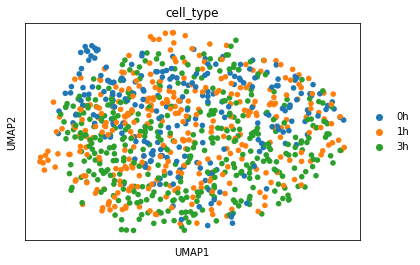

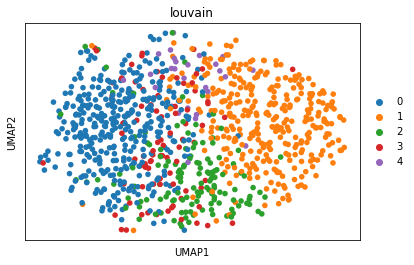

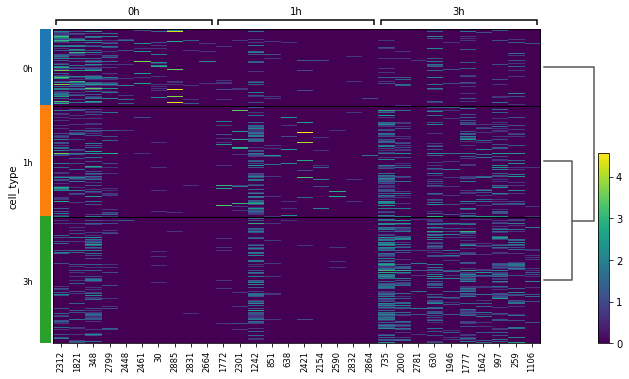

In [17]:

# visulization
prior_adata = anndata.AnnData(X=exps)
prior_adata.obsm["X_multi_vi"] = exps
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
sc.tl.umap(prior_adata, min_dist=0.3)

sc.tl.louvain(prior_adata)
originalcell=prior_adata.obs['louvain']
prior_adata.obs['cell_type'] = temp1
# origin cell label
sc.pl.umap(prior_adata, color=['cell_type'], show=False)
plt.savefig("%s/exp_actual_label.pdf" % output_path, format="pdf")
# origin cell label
sc.pl.umap(prior_adata, color=['louvain'], show=False)
sc.tl.rank_genes_groups(prior_adata, 'cell_type', method="t-test")
sc.pl.rank_genes_groups_heatmap(prior_adata, n_genes=10, groupby='cell_type', show=False)
plt.savefig("%s/exp_heatmap.pdf" % output_path, format="pdf")
groundtruth=prior_adata.obs['cell_type']


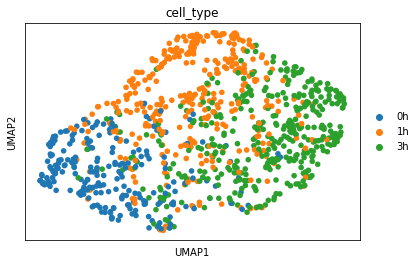

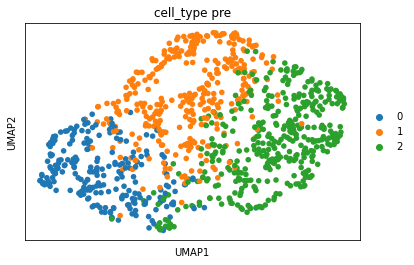

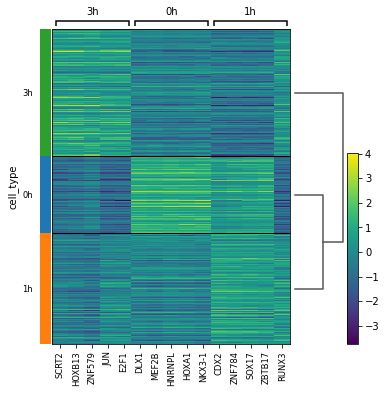

In [18]:
genename=pd.DataFrame(tfname.index)
tfname1=pd.DataFrame(tfname.columns)
prior_adata1 = anndata.AnnData(X=ztf,var=tfname1)
prior_adata1.obsm["X_multi_vi"] = ztf
sc.pp.neighbors(prior_adata1, use_rep="X_multi_vi", n_neighbors=20)
sc.tl.umap(prior_adata1, min_dist=0.3)

sc.tl.louvain(prior_adata1)
prior_adata1.obs['cell_type'] = temp1
# origin cell label
sc.pl.umap(prior_adata1, color=['cell_type'], show=False)

plt.savefig("%s/ztf_actual_labl.pdf" % output_path, format="pdf")
# plt.show()
prior_adata1.obs['cell_type pre'] = temppre
# origin cell label
sc.pl.umap(prior_adata1, color=['cell_type pre'], show=False)
plt.savefig("%s/ztf_predict_labl.pdf" % output_path, format="pdf")
prior_adata1.var.index=prior_adata1.var[0]
sc.tl.rank_genes_groups(prior_adata1, 'cell_type', method="t-test")
sc.pl.rank_genes_groups_heatmap(prior_adata1, n_genes=5, groupby='cell_type', show=False)
plt.savefig("%s/ztf_heatmap.pdf" % output_path, format="pdf")
